In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import shutil
from zipfile import ZipFile
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from utils import get_image_paths, word_from_image_path, preprocess_image, print_im, TextTransform, N_CHARS, SEQUENCE_LENGTH, IMAGE_DIMENSIONS
from tqdm import tqdm, tqdm_notebook
from utils import plot_batch_images

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from multi_gpu import make_parallel

### Read data

In [4]:
import h5py, pickle
import numpy as np

In [123]:
# %%time
# with h5py.File('/mnt/x_5m_minus_min_div_std.h5', 'r') as hf:
#     x = hf['x'][:]
# with h5py.File('/mnt/y.h5', 'r') as hf:
#     y = hf['x'][:]

### Verifying Images / Labels

In [122]:
# x.shape, y.shape
# y = y[:x.shape[0]]

# Removal of empty labels

# with open('/datadrive/tt_new.pickle', 'rb') as f:
#     tt = pickle.load(f)

# empty_labels =[]
# for i in range(x.shape[0]):
#     if tt.word_from_matrix(y[i]) == '':
#         empty_labels.append(i)

# x = x[~np.in1d(range(x.shape[0]),empty_labels)]
# y = y[~np.in1d(range(y.shape[0]),empty_labels)]
# (x.shape, y.shape)

# import pickle
# with open('/datadrive/tt_new.pickle', 'rb') as f:
#     tt = pickle.load(f)

# plot_batch_images(x,y)

### dump std, mean

In [13]:
# mean2 = x.mean(axis=0)
# print(mean2.shape)

# %%time
# std = x.std(axis=(0))

# x = (x - mean2) / (std + 0.0001)

# # %%time
# # x = (x - mean.reshape((-1, 1, 1))) / std.reshape((-1, 1, 1))

(32, 100)


### load final x and y

In [ ]:
%%time
with h5py.File('/mnt/x_5m_2ndprocess.h5', 'r') as hf:
    x = hf['x'][:]
with h5py.File('/mnt/y_5m_2ndprocess.h5', 'r') as hf:
    y = hf['x'][:]

In [120]:
y.shape, x.shape

((4998656, 23, 37), (4998656, 32, 100))

### Model creation

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Reshape, Activation
from keras.layers import Flatten

In [41]:
from utils import IMAGE_DIMENSIONS, SEQUENCE_LENGTH, N_CHARS

In [107]:
convolutions = [64, 128, 256, 512, 512]
kernels = [3, 3, 3, 3, 3]

model = Sequential()
input_shape = (None,) + IMAGE_DIMENSIONS + (1,)

model.add(Conv2D(nb_filter=64,
                     nb_row=kernels[0],
                     nb_col=kernels[0],
                     activation='relu',
                     border_mode='same',
                     batch_input_shape=input_shape, name="convo" + str(0)))

model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))

for i, (kernel, convolution_size) in enumerate(zip(kernels[1:], convolutions[1:])):
    model.add(Conv2D(nb_filter=convolution_size,
                     nb_row=kernel,
                     nb_col=kernel,
                     activation='relu',
                     border_mode='same',
                     name="convo" + str(i + 1)))
    
    if i <= 1 :
        model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same',))

model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(4096, activation='relu', name="Dense1"))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', name="Dense2"))
model.add(Dropout(0.5))

model.add(Dense(SEQUENCE_LENGTH * N_CHARS, name="Dense3") )
model.add(Reshape((SEQUENCE_LENGTH, N_CHARS)))
model.add(Activation('softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy')

### Loading Pretrained kernels

In [ ]:
from utils import load_trained_CNN_weights
model = load_trained_CNN_weights("/datadrive/p_model_20.h5", dense_layer=False)

In [43]:
# from keras.applications import VGG16

# vgg = VGG16()

# vgg_convo0 = vgg.get_layer(name='block1_conv1')
# vgg_convo1 = vgg.get_layer(name='block2_conv1')

# w0,b0 = vgg_convo0.get_weights()
# w1,b1 = vgg_convo1.get_weights()
# print (w0.shape, b0.shape)
# print (w1.shape, b1.shape)

# convo = model.get_layer(name="convo0")
# convo.set_weights([w0[:,:,0,:].reshape((3,3,1,64)), b0])

# convo = model.get_layer(name="convo1")
# convo.set_weights([w1, b1])

# model.save('model_pretrained_weights.keras')

### Training model

In [50]:
one_million = 1000000
hundred_thousands = 100000
thousands = 1024

In [51]:
x.shape, y.shape

((4998717, 32, 100), (4998717, 23, 37))

In [78]:
len(x) % (4*32)

0

In [80]:
# len(x) doit etre un multiple de 4
# x = x[:-61]
# y = y[:-61]
len(x) % (4*32) == 0

True

In [52]:
# y = y.reshape((y.shape[0],23,37))

In [53]:
import datetime

In [ ]:
p_model = make_parallel(model, 4)
p_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [67]:
for i in range(1):
    begin = ((i - 1) % 50) * hundred_thousands
    end = (((i - 1) % 50) + 1) * hundred_thousands
    run = i // 50 + 1
    
    x_batch = x[begin:end]
    y_batch = y[begin:end]
    print(len(x_batch))
    
    history = p_model.fit(x_batch.reshape((x_batch.shape[0],) + IMAGE_DIMENSIONS + (1,)), y_batch, nb_epoch=1)
    
    now = datetime.datetime.now().isoformat().split('.')[0]

    with open("/datadrive/state", 'a+') as f:
        f.write("run={} epoch={} loss={} now={} from={} to={}\n".format(run, (i - 1) % 50, history.history['loss'][0], now, begin, end))
    
    if i and not i % 10:
        p_model.save('/datadrive/p_model_{}.h5'.format(i))

1024
Epoch 1/1
1024/1024 [==============================] - 5s - loss: 0.8431     

### Predictions

In [94]:
predictions = p_model.predict(x[:20].reshape((x[:20].shape[0],) + IMAGE_DIMENSIONS + (1,)))

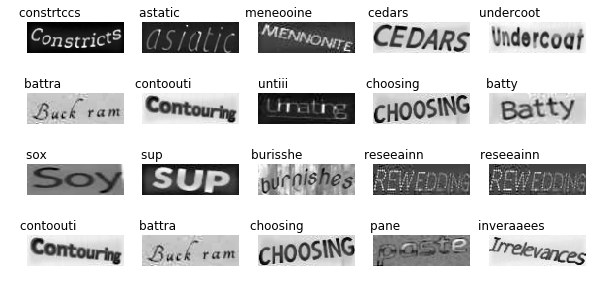

In [101]:
plot_batch_images(x[:20], predictions)